# Compute profiles

Compute profiles in the ocean using the variable of choice

### Import packages

In [1]:
import numpy as np
#from netCDF4 import Dataset
import xarray as xr
import glob
import sys
#import os
#import shutil
#import copy
#import cftime

import matplotlib.pyplot as plt

## Define area and data

In [3]:
ENS     = 2
region  = 'atlmsk'
imin    = -75
imax    = -7.5
jmin    = 0
jmax    = 60
var     = 'votemper'
outfile = '/home/users/jmecking001/DATADIR/CANARI/users/jmecking001/amv_profile.nc'

datadir   = ('/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/' + str(ENS) + '/')
meshmask  = '/gws/nopw/j04/canari/shared/large-ensemble/ocean/mesh_mask.nc' 
basinfile = '/gws/nopw/j04/canari/shared/large-ensemble/ocean/subbasins.nc'

# List all files required for the computation:
infiles = glob.glob((datadir + 'OCN/yearly/*/*_' + var + '.nc'))


In [7]:
# Determine grid of data:
o_grid = infiles[0].split('_')[-2]

In [6]:
mmask = xr.open_mfdataset(meshmask)
lon   = mmask[('glam' + Ogrid.lower())][0,:,:].to_numpy()  # Not that the longitudes are all between -180 and 180
lat   = mmask[('gphi' + Ogrid.lower())][0,:,:].to_numpy()

In [8]:
basin = xr.open_mfdataset(basinfile)
bmask = basin[region].to_numpy()

In [9]:
# Mask out any area not in the desired region and compute the smallest region needed to read in to save time:
if imin > imax:
    bmask[np.where(((lat < jmin) | (lat > jmax)) | ((lon < imin) & (lon > imax)))] = 0
else:
    bmask[np.where(((lat < jmin) | (lat > jmax)) | ((lon < imin) | (lon > imax)))] = 0

In [10]:
# Only read in data that's required, otherwise it slows down the computation:
inds = np.asarray(np.where(bmask == 1))
xmin = np.min(np.squeeze(inds[1,:]))
xmax = np.max(inds[1,:])
ymin = np.min(inds[0,:])
ymax = np.max(inds[0,:])

In [11]:
tmask     = mmask[(o_grid.lower() + 'mask')][0,:,ymin:ymax+1,xmin:xmax+1].to_numpy()
nk        = np.size(tmask,axis=0)
dx        = mmask[('e1' + o_grid.lower())][0,ymin:ymax+1,xmin:xmax+1].to_numpy()
dy        = mmask[('e2' + o_grid.lower())][0,ymin:ymax+1,xmin:xmax+1].to_numpy()
area_box  = dx*dy*bmask[ymin:ymax+1,xmin:xmax+1]
bmask_box = tmask*np.tile(bmask[ymin:ymax+1,xmin:xmax+1]*area_box,(nk,1,1))
areaxy    = np.sum(np.sum(bmask_box,axis=2),axis=1)

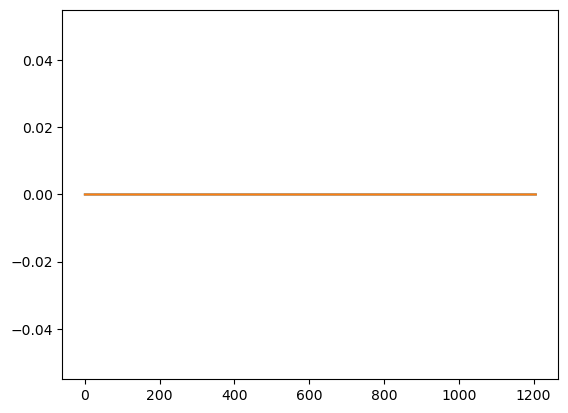

In [12]:
plt.plot(lon[:,0]-lon[:,-2])
plt.plot(lon[:,1]-lon[:,-1])
#plt.plot(lon[:,-1])
#plt.plot(lon[:,-2])

In [13]:
t_data = xr.open_mfdataset(infiles)

In [14]:
nt = t_data.sizes['time_counter']

profile = np.zeros((nt,nk),'float')

for tt in range(0,50):#nt):
    print('computing month ' + str(tt+1) + ' of ' + str(nt))
    box_data = t_data[var][tt,:,ymin:ymax+1,xmin:xmax+1].to_numpy()
    profile[tt,:] = np.nansum(np.nansum(box_data*bmask_box,axis=2),axis=1)/areaxy

computing month 1 of 780


/tmp/ipykernel_7252/186401844.py:8: RuntimeWarning: invalid value encountered in divide
  profile[tt,:] = np.nansum(np.nansum(box_data*bmask_box,axis=2),axis=1)/areaxy


computing month 2 of 780
computing month 3 of 780
computing month 4 of 780
computing month 5 of 780
computing month 6 of 780
computing month 7 of 780
computing month 8 of 780
computing month 9 of 780
computing month 10 of 780
computing month 11 of 780
computing month 12 of 780
computing month 13 of 780
computing month 14 of 780
computing month 15 of 780
computing month 16 of 780
computing month 17 of 780
computing month 18 of 780
computing month 19 of 780
computing month 20 of 780
computing month 21 of 780
computing month 22 of 780
computing month 23 of 780
computing month 24 of 780
computing month 25 of 780
computing month 26 of 780
computing month 27 of 780
computing month 28 of 780
computing month 29 of 780
computing month 30 of 780
computing month 31 of 780
computing month 32 of 780
computing month 33 of 780
computing month 34 of 780
computing month 35 of 780
computing month 36 of 780
computing month 37 of 780
computing month 38 of 780
computing month 39 of 780
computing month 40 o

In [18]:
# Save profile to netcdf file (This is what I wanted to do to preserve the netcdf metadata - My xarray ability is really terrible):
t_profile = t_data.isel(x=0,y=0)
t_profile = t_profile.drop_vars(['nav_lon','nav_lat','x','y','bounds_nav_lon','bounds_nav_lat','deptht_bounds'])
t_profile[var][:,:] = profile
# t_profile.to_netcdf(outfile) # Uncomment to create a netcdf file

In [19]:
t_profile

<xarray.Dataset> Size: 253kB
Dimensions:              (time_counter: 780, axis_nbounds: 2, deptht: 75)
Coordinates:
  * time_counter         (time_counter) object 6kB 1950-01-16 00:00:00 ... 20...
  * deptht               (deptht) float32 300B 0.5058 1.556 ... 5.902e+03
Dimensions without coordinates: axis_nbounds
Data variables:
    time_counter_bounds  (time_counter, axis_nbounds) object 12kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    votemper             (time_counter, deptht) float32 234kB dask.array<chunksize=(1, 19), meta=np.ndarray>
Attributes: (12/35)
    Conventions:            CF-1.10
    parent_variant_label:   r1i1p1f3
    project:                Coupled Climate
    realm:                  ocean
    institution:            NCAS
    experiment:             HIST2
    ...                     ...
    parent_source_id:       CMIP6.CMIP.MOHC.HadGEM3-GC31-MM.historical.r1i1p1f3
    parent_mip_era:         CMIP6
    physics_index:          2
    parent_experiment_id:   historical
    source_type:            AOGCM
    external_variables:     areacello

### Plot box data

In [22]:
# box_data # uncomment to see box data

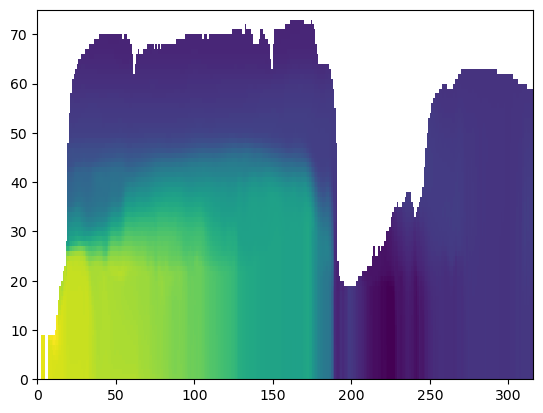

In [26]:
plt.pcolormesh(box_data[:,:,100])

In [9]:
Tdata.sizes['time_counter']

780

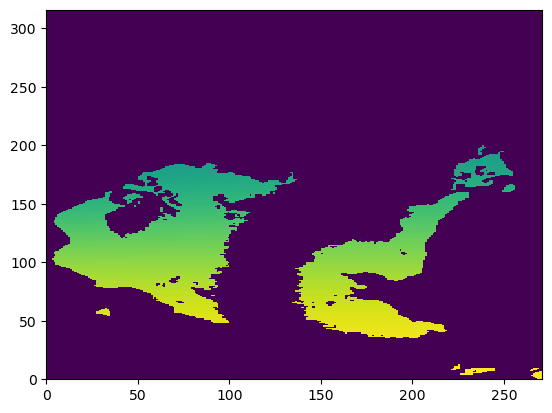

In [29]:
plt.pcolormesh(bmask_box[70,:,:])

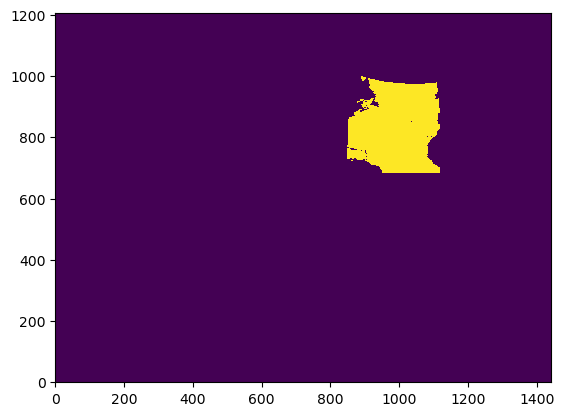

In [28]:
plt.pcolormesh(bmask)